# Investment Property Tool

## CS410 Project

Submitted By: Anish Abraham
    
Date        : December 14, 2018


## Project Overview:

There are several property websites where buyers can browse through properties listed for sale and get more details like viewing pictures and locations. However, property market is not very liquid and determining a fair price for a property is not very straightforward. 

An investor or even someone looking for a home and keen to personalize the home to their liking would prefer to purchase an undervalued home and spend money to personalize the property. It is always a challenge for the prospective buyer to determine whether the home which he is trying to buy is worth the money spent. 

This project tries to solve the problem by building a predictive model for finding the value with text retrieval and mining techniques. There are several websites which showcases the estimated price and the actual price of a property there by giving the customer a way to understand whether the amount they are spending is comparable to the estimated price of that property. Here we are trying to predict the value of the homes there by the customer will have a baseline for all the different homes irrespective of the location or the year in which it was built or the facilities available in that home. 

Zillow is one of the popular property listing websites in US. Using Zillow's GetUpdatedPropertyDetails API, we extracted the data. This data included details like full address, posting details, images, home facts such as bedrooms, bathrooms, year built, squarefoot, roof type, number of rooms, home description, neighborhood and school information.

### Problem Statement

Determining the value for money for a real estate property is not that easy. Different websites shows different estimated price for the same/ or similar property. This is primarily because of the way in which the features are being selected for obtaining the estimate. 

### Proposed Solution

The current property websites does not showcase the real value of a property which could be used to compare multiple properties. Hence we are trying to build a predictive model for finding the value by feature extraction involving textual data. The intended workflow for this project is mentioned below.

1. Extract the data from Zillow website using API GetUpdatedPropertyDetails.
    - Using the zillow ID , extract a range of data.
    - Store the deisred columns during the scraping process.
    - Validate the data before storing the field values.
    - Skip the values if the corresponding column is missing in the XML response.
    
    
2. Preprocess the data
    - Remove features which are not helpful for predicting the value.
    - Remove incomplete listings if the major feature values are missing.
    - Impute missing values: most frequent for text and median for others.
        
     
3. Feature Engineering
    - Topic modeling using LDA.
    - Convert corpus into Document Term Matrix
    
   
4. Build the model
    - Linear regression method is used to build the model.
    - Train the model
    
    
5. Test the model
    - Test the model built
    - Mean squared error is used for measuring model accuracy.
    

6. Explore other characterisitcs of the data
    - Bag of words representation
    - TF-IDF
    



### Initial Setup

In [1]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import nltk
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.ldamodel import LdaModel

import itertools
from collections import Counter
#from collections import defaultdict

C:\Users\anish\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Read the CSV file generated using the API

In [2]:
df = pd.read_csv('HousingData_Zillow_final.csv',  encoding='latin-1',header=0, index_col=0)
df.head()

,street,zipcode,city,state,latitude,longitude,price,bedrooms,bathrooms,finishedSqFt,...,yearUpdated,numFloors,view,parkingType,heatingSources,heatingSystem,rooms,neighborhood,schoolDistrict,homeDescription
zpid,,,,,,,,,,,,,,,,,,,,,
40000003,60 Montrose Ave,7023.0,FANWOOD,NJ,40.649677,-74.389070,NaN,3.0,1.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beautifully maintained and landscaped home con...
40000004,117 Pleasant Ave,7023.0,FANWOOD,NJ,40.649500,-74.388788,NaN,4.0,2.5,1641.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40000009,79 Pleasant Ave,7023.0,FANWOOD,NJ,40.648488,-74.389920,NaN,4.0,2.5,1969.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Totally renovated colonial, open floor plan, h..."
40000010,75 Pleasant Ave,7023.0,FANWOOD,NJ,40.648331,-74.390096,NaN,3.0,2.0,1415.0,...,NaN,2.0,NaN,Garage - Attached,Gas,"Baseboard, Other","Office, Workshop, Family room, Laundry room",NaN,NaN,NEW PRICE!!!!! POSSIBILITIES ARE ENDLESS FOR S...
40000012,61 Pleasant Ave,7023.0,FANWOOD,NJ,40.648016,-74.390447,NaN,4.0,2.0,1356.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Charming Cape Cod Style home with an Oversized...


In [3]:
print("Dataframe has {} rows and {} columns.".format(*df.shape))

Dataframe has 1063 rows and 22 columns.


### Data Exploration

The dataset extracted through the Zillow API has 1063 rows and 22 columns. Based on the available column values we need to downselect the relevant features. here ideally we should include more features which we could use to determine the value. The current dataset have only limited information. Hence we are selecting the relevant features from the set available.

The 14 features downselected are as follows.

    homeDescription - Home description 
    latitude        - Latitude of property
    longitude       - Longitude of property  
    bedrooms        - Number of bedrooms 
    bathrooms       - Number of bathrooms
    finishedSqFt    - Size of home
    lotSizeSqFt     - Size of the lot
    yearBuilt       - Year in which the home was built
    yearUpdated     - Year in which home was last modified
    numFloors       - Number of floors
    parkingType     - Parking facility
    heatingSources  - Sources used for heating
    heatingSystem   - Heating systems available 
    rooms           - Type of rooms

In [4]:
df.columns = df.columns.to_series().apply(lambda x: x.strip())
print(list(df))

['street', 'zipcode', 'city', 'state', 'latitude', 'longitude', 'price', 'bedrooms', 'bathrooms', 'finishedSqFt', 'lotSizeSqFt', 'yearBuilt', 'yearUpdated', 'numFloors', 'view', 'parkingType', 'heatingSources', 'heatingSystem', 'rooms', 'neighborhood', 'schoolDistrict', 'homeDescription']


In [5]:
# Select the features from the data
#House_data = House_data[[0,1,2]]
df = df[[ 'homeDescription', 'latitude', 'longitude', 'bedrooms', 'bathrooms','finishedSqFt', 'lotSizeSqFt','yearBuilt', 'yearUpdated', 'numFloors', 'parkingType', 'heatingSources', 'heatingSystem', 'rooms' ]]

print("Dataframe has {} rows and {} columns.".format(*df.shape))
df.head()

Dataframe has 1063 rows and 14 columns.


,homeDescription,latitude,longitude,bedrooms,bathrooms,finishedSqFt,lotSizeSqFt,yearBuilt,yearUpdated,numFloors,parkingType,heatingSources,heatingSystem,rooms
zpid,,,,,,,,,,,,,,
40000003,Beautifully maintained and landscaped home con...,40.649677,-74.389070,3.0,1.5,NaN,10454.0,1964.0,NaN,NaN,NaN,NaN,NaN,NaN
40000004,NaN,40.649500,-74.388788,4.0,2.5,1641.0,9583.0,1951.0,NaN,NaN,NaN,NaN,NaN,NaN
40000009,"Totally renovated colonial, open floor plan, h...",40.648488,-74.389920,4.0,2.5,1969.0,7501.0,1950.0,NaN,NaN,NaN,NaN,NaN,NaN
40000010,NEW PRICE!!!!! POSSIBILITIES ARE ENDLESS FOR S...,40.648331,-74.390096,3.0,2.0,1415.0,7405.0,1950.0,NaN,2.0,Garage - Attached,Gas,"Baseboard, Other","Office, Workshop, Family room, Laundry room"
40000012,Charming Cape Cod Style home with an Oversized...,40.648016,-74.390447,4.0,2.0,1356.0,7501.0,1954.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
a = df['bedrooms'].unique()
print (sorted(a))

[1.0, 3.0, 4.0, nan, 2.0, 5.0, 6.0, 7.0, 8.0, 9.0]


#### Cleanse numeric features

In [7]:

numeric_features = ['bedrooms', 'bathrooms','finishedSqFt', 'lotSizeSqFt','yearBuilt', 'yearUpdated', 'numFloors']
df[numeric_features] = df[numeric_features].replace('[\$,]', '', regex=True)
df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
print("Dataframe has {} rows and {} columns.".format(*df.shape))


Dataframe has 1063 rows and 14 columns.


#### Summary of all selected columns

In [8]:

df.describe()

,latitude,longitude,bedrooms,bathrooms,finishedSqFt,lotSizeSqFt,yearBuilt,yearUpdated,numFloors
count,1058.000000,1058.000000,1017.000000,1018.000000,884.000000,1.055000e+03,1002.000000,171.000000,518.000000
mean,40.648493,-74.359670,3.411996,2.057024,1926.830317,3.036242e+05,1946.416168,2004.619883,2.009653
std,0.041694,0.050001,0.917016,0.740082,3410.255988,9.346682e+06,23.126708,16.354581,0.647793
min,39.835319,-74.776126,1.000000,1.000000,1.000000,5.200000e+01,1830.000000,1924.000000,1.000000
25%,40.638829,-74.387120,3.000000,1.500000,1347.500000,5.462500e+03,1930.000000,2005.000000,2.000000
50%,40.644940,-74.381143,3.000000,2.000000,1641.500000,7.405000e+03,1950.000000,2008.000000,2.000000
75%,40.650111,-74.327818,4.000000,2.500000,2060.500000,9.583000e+03,1957.000000,2013.000000,2.000000
max,41.161080,-74.121724,9.000000,5.500000,99999.000000,3.035696e+08,2018.000000,2018.000000,5.000000


#### Remove the outliers

In [9]:
# Remove where bedroom is more than 6
df = df.query('bedrooms <= 6')
print("Dataframe has {} rows and {} columns.".format(*df.shape))

Dataframe has 1012 rows and 14 columns.


In [10]:
a = df['bedrooms'].unique()
print (sorted(a))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0]


#### Frequency of parkingType

In [11]:
# rare category
df['parkingType'].value_counts()

Garage - Attached                                              295
Garage - Detached                                              120
Off-street                                                      41
Garage - Attached, Off-street                                   27
Garage - Detached, Off-street                                   20
On-street                                                       17
Off-street, On-street                                           13
Garage - Attached, Off-street, On-street                        11
Garage - Attached, On-street                                     8
Garage - Detached, Off-street, On-street                         8
Garage - Detached, On-street                                     5
None                                                             3
Garage - Attached, On-street, Off-street                         1
Garage - Attached, Garage - Detached, Off-street, On-street      1
Garage - Detached, Garage - Attached, Off-street              

In [12]:
df.head()

,homeDescription,latitude,longitude,bedrooms,bathrooms,finishedSqFt,lotSizeSqFt,yearBuilt,yearUpdated,numFloors,parkingType,heatingSources,heatingSystem,rooms
zpid,,,,,,,,,,,,,,
40000003,Beautifully maintained and landscaped home con...,40.649677,-74.389070,3.0,1.5,NaN,10454.0,1964.0,NaN,NaN,NaN,NaN,NaN,NaN
40000004,NaN,40.649500,-74.388788,4.0,2.5,1641.0,9583.0,1951.0,NaN,NaN,NaN,NaN,NaN,NaN
40000009,"Totally renovated colonial, open floor plan, h...",40.648488,-74.389920,4.0,2.5,1969.0,7501.0,1950.0,NaN,NaN,NaN,NaN,NaN,NaN
40000010,NEW PRICE!!!!! POSSIBILITIES ARE ENDLESS FOR S...,40.648331,-74.390096,3.0,2.0,1415.0,7405.0,1950.0,NaN,2.0,Garage - Attached,Gas,"Baseboard, Other","Office, Workshop, Family room, Laundry room"
40000012,Charming Cape Cod Style home with an Oversized...,40.648016,-74.390447,4.0,2.0,1356.0,7501.0,1954.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Calculate the 'value'
With the available features we could try to calculate the value of the listing.

Value  = (no:of bedrooms) X (no: of bathrooms) X (home sqft) X (no: of floors) X (year built)

Potentially the other features such as year built and the year updated could also be used. Also offsetting the value could also be considered.

C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


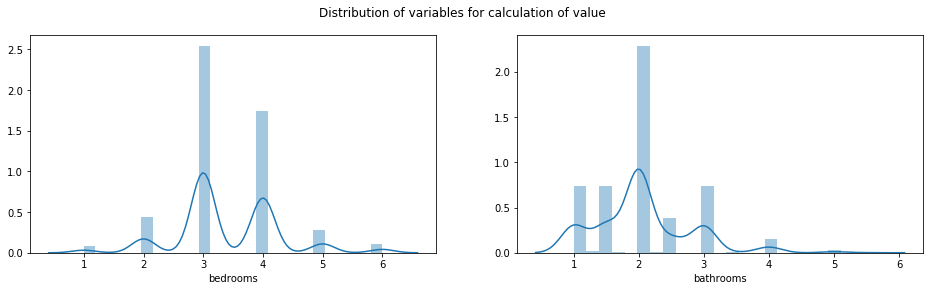

In [13]:
#Distribution of value
%matplotlib inline

fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of variables for calculation of value')
x_axis=df['bedrooms'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[0])
x_axis=df['bathrooms'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[1])


C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


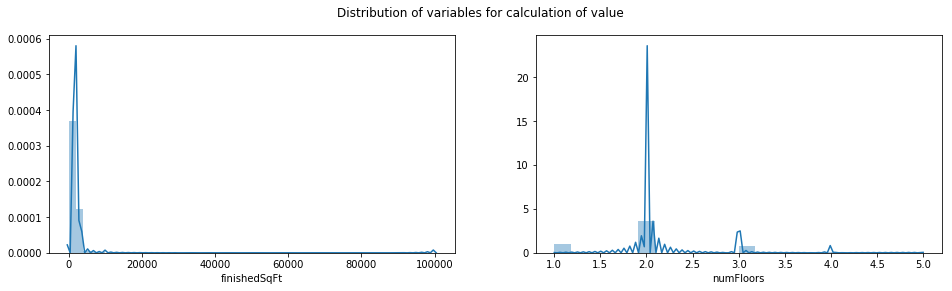

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4))
fig.suptitle('Distribution of variables for calculation of value')

x_axis=df['finishedSqFt'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[0])
x_axis=df['numFloors'].dropna()
sns.distplot(pd.Series(x_axis, name=x_axis.name), ax=axs[1])


In [15]:
# Calculate value

#Value  = bed*bath*sqft*floor*builtyear

df['value'] = df['bedrooms'] *  df['bathrooms'] * df['finishedSqFt'] * df['numFloors'] * df['yearBuilt'] 


print("Dataframe has {} rows and {} columns.".format(*df.shape))

Dataframe has 1012 rows and 15 columns.


C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\anish\AppData\Roaming\Python\Python36\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


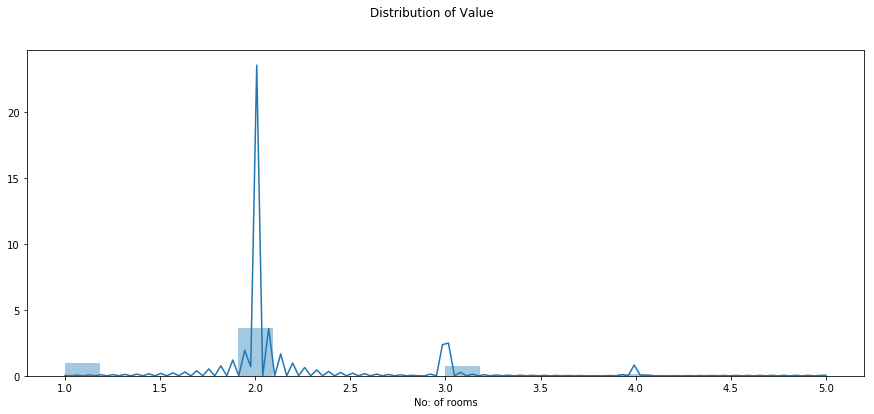

In [16]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,6))
fig.suptitle('Distribution of Value' )
x_axes = df['value'].dropna()
x = pd.Series(x_axis, name='No: of rooms')
ax = sns.distplot(x)

#### Summary of calculated value

In [17]:
df['value'].describe()

count    4.320000e+02
mean     7.348704e+07
std      8.553314e+07
min      1.158000e+05
25%      3.008081e+07
50%      4.863997e+07
75%      8.122338e+07
max      8.819118e+08
Name: value, dtype: float64

In [18]:
df.head()

,homeDescription,latitude,longitude,bedrooms,bathrooms,finishedSqFt,lotSizeSqFt,yearBuilt,yearUpdated,numFloors,parkingType,heatingSources,heatingSystem,rooms,value
zpid,,,,,,,,,,,,,,,
40000003,Beautifully maintained and landscaped home con...,40.649677,-74.389070,3.0,1.5,NaN,10454.0,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40000004,NaN,40.649500,-74.388788,4.0,2.5,1641.0,9583.0,1951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40000009,"Totally renovated colonial, open floor plan, h...",40.648488,-74.389920,4.0,2.5,1969.0,7501.0,1950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40000010,NEW PRICE!!!!! POSSIBILITIES ARE ENDLESS FOR S...,40.648331,-74.390096,3.0,2.0,1415.0,7405.0,1950.0,NaN,2.0,Garage - Attached,Gas,"Baseboard, Other","Office, Workshop, Family room, Laundry room",33111000.0
40000012,Charming Cape Cod Style home with an Oversized...,40.648016,-74.390447,4.0,2.0,1356.0,7501.0,1954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Missing values

The dataframe has missing values in some features such as yearUpdated, numFloors, parkingType and heatingSources. If majority of the values are missing for a column, we should remove that.

We can now impute the missing values. Categorical features needs to be imputed with most frequent category and numerical features with median.

In [19]:
sum(pd.isnull(df['numFloors']))

513

In [20]:
from sklearn.base import TransformerMixin

class ImputeDataSet(TransformerMixin):

    def __init__(self):
        """Impute missing values
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [21]:
# Remove missing values
df = df.dropna(subset=['value'])

In [22]:
# Imputing most frequent for categorical features
categorical_features = df.select_dtypes(include=['object']).columns
df[categorical_features] = ImputeDataSet().fit_transform(df[categorical_features])

# Imputing median for numerical features
numeric_features = df.select_dtypes(include=[np.number]).columns
imp = Imputer(missing_values=np.nan, strategy='median', axis=0)
df[numeric_features] = imp.fit_transform(df[numeric_features])

print("Dataframe has {} rows and {} columns.".format(*df.shape))

Dataframe has 432 rows and 15 columns.


In [23]:
df.isnull().sum(axis=0)

homeDescription    0
latitude           0
longitude          0
bedrooms           0
bathrooms          0
finishedSqFt       0
lotSizeSqFt        0
yearBuilt          0
yearUpdated        0
numFloors          0
parkingType        0
heatingSources     0
heatingSystem      0
rooms              0
value              0
dtype: int64

In [24]:
# check for any nulls in the final dataframe
df.isnull().values.any()

False

### Topic Modeling

We are using a Natural Language Processing pipeline for converting the corpus into a document-term-matrix. Then apply the Latent Dirrichlet Allocation (LDA) to discover inherent topics in the corpus. Classify this corpus according to the topics learned and use them as features for the regression model.

LDA is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar.

In [25]:
#Topic Model

# Seperate NLP features
nlp_features = ['homeDescription']
corpus = df[nlp_features]
df = df.drop(nlp_features, axis = 1)
print("Dataframe has {} rows and {} columns.".format(*df.shape))

Dataframe has 432 rows and 14 columns.


In [26]:
def text_preprocess(corpus):
    """Applies basic preprocessing steps to a corpus in list format. 
    Word tokenization, removal of English stop words, convert to lower case
    and lemmatization are done."""
    modified_corpus = []
    english_words = set(nltk.corpus.words.words())
    english_stopwords = set(stopwords.words('english'))
    wordnet_lemmatizer = WordNetLemmatizer()
    tokenizer = RegexpTokenizer(r'[\w|!]+')
    for row in corpus:
        word_tokens = tokenizer.tokenize(row)
        word_tokens_lower = [t.lower() for t in word_tokens]
        word_tokens_lower_english = [t for t in word_tokens_lower if t in english_words or not t.isalpha()]
        word_tokens_no_stops = [t for t in word_tokens_lower_english if not t in english_stopwords]
        word_tokens_no_stops_lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in word_tokens_no_stops]
        modified_corpus.append(word_tokens_no_stops_lemmatized)
    return modified_corpus

In [27]:
def nlp_pipeline(modified_corpus):
    """Takes processed corpus and produce dictionary, doc_term_matrix and LDA model"""
    # Creates the term dictionary (every unique term in corpus is assigned an index)
    dictionary = Dictionary(modified_corpus)
    # Convert corpus into Document Term Matrix using dictionary prepared above
    doc_term_matrix = [dictionary.doc2bow(listing) for listing in modified_corpus]    
    return dictionary, doc_term_matrix

In [28]:
def Topic_modelling_LDA(doc_term_matrix, dictionary, num_topics=3, passes=2):
    # Create an object for LDA model and train it on Document-Term-Matrix
    LDA = LdaModel
    ldamodel = LDA(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=passes)
    return ldamodel

In [29]:
corpus.head()

,homeDescription
zpid,
40000010,NEW PRICE!!!!! POSSIBILITIES ARE ENDLESS FOR S...
40000018,Welcome home to this fabulous 1500 Sq Ft Henry...
40000025,Charming traditional elements and modern conve...
40000028,A welcoming entry opens to a spectacular home ...
40000029,A welcoming entry opens to a spectacular home ...


In [30]:
corpus_description = corpus['homeDescription'].astype(str)
modified_corpus_description = text_preprocess(corpus_description)
dictionary_description, doc_term_matrix_description = nlp_pipeline(modified_corpus_description)

In [31]:
print(dictionary_description)

Dictionary(1573 unique tokens: ['1', '1st', '2', '2nd', '9x7']...)


In [32]:
print(doc_term_matrix_description)

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 5), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1)], [(8, 1), (17, 1), (19, 1), (24, 1), (26, 1), (28, 1), (31, 2), (32, 1), (36, 3), (41, 1), (45, 1), (46, 1), (54, 1), (56, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 4), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 2), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1),

In [33]:
ldamodel_description = Topic_modelling_LDA(doc_term_matrix_description, dictionary_description, num_topics=3, passes=1)

In [34]:
print('ldamodel_description')

ldamodel_description


In [35]:
print("Dataframe has {} rows and {} columns.".format(*df.shape))
df.head()

Dataframe has 432 rows and 14 columns.


,latitude,longitude,bedrooms,bathrooms,finishedSqFt,lotSizeSqFt,yearBuilt,yearUpdated,numFloors,parkingType,heatingSources,heatingSystem,rooms,value
zpid,,,,,,,,,,,,,,
40000010,40.648331,-74.390096,3.0,2.0,1415.0,7405.0,1950.0,2008.0,2.0,Garage - Attached,Gas,"Baseboard, Other","Office, Workshop, Family room, Laundry room",33111000.0
40000018,40.648321,-74.389390,3.0,2.0,1610.0,7405.0,1960.0,2008.0,1.0,Garage - Attached,Gas,Forced air,Dining room,18933600.0
40000025,40.646639,-74.388248,3.0,2.0,1289.0,6969.0,1925.0,2001.0,4.0,Garage - Detached,Gas,Baseboard,"Family room, Pantry",59551800.0
40000028,40.647154,-74.387803,5.0,4.0,3993.0,21052.0,2013.0,2013.0,2.0,Garage - Attached,Gas,Forced air,"Dining room, Family room, Laundry room, Master...",321516360.0
40000029,40.647189,-74.387409,4.0,3.0,1712.0,11848.0,1932.0,2008.0,2.0,Garage - Detached,Gas,Forced air,"Dining room, Family room, Master bath, Mud room",79382016.0


In [36]:
# Dummy encoding
categorical_features = ['parkingType', 'heatingSources', 'heatingSystem', 'rooms' ]
df = pd.get_dummies(df, columns=categorical_features, drop_first=False)
print("Dataframe has {} rows and {} columns.".format(*df.shape))

Dataframe has 432 rows and 236 columns.


In [37]:
df.head()

,latitude,longitude,bedrooms,bathrooms,finishedSqFt,lotSizeSqFt,yearBuilt,yearUpdated,numFloors,value,...,"rooms_Pantry, Family room, Laundry room, Dining room","rooms_Recreation room, Dining room, Laundry room","rooms_Recreation room, Sun room",rooms_Sun room,"rooms_Sun room, Dining room","rooms_Sun room, Family room",rooms_Walk-in closet,"rooms_Walk-in closet, Family room, Dining room","rooms_Walk-in closet, Master bath, Laundry room, Family room, Dining room","rooms_Workshop, Family room, Laundry room, Dining room"
zpid,,,,,,,,,,,,,,,,,,,,,
40000010,40.648331,-74.390096,3.0,2.0,1415.0,7405.0,1950.0,2008.0,2.0,33111000.0,...,0,0,0,0,0,0,0,0,0,0
40000018,40.648321,-74.389390,3.0,2.0,1610.0,7405.0,1960.0,2008.0,1.0,18933600.0,...,0,0,0,0,0,0,0,0,0,0
40000025,40.646639,-74.388248,3.0,2.0,1289.0,6969.0,1925.0,2001.0,4.0,59551800.0,...,0,0,0,0,0,0,0,0,0,0
40000028,40.647154,-74.387803,5.0,4.0,3993.0,21052.0,2013.0,2013.0,2.0,321516360.0,...,0,0,0,0,0,0,0,0,0,0
40000029,40.647189,-74.387409,4.0,3.0,1712.0,11848.0,1932.0,2008.0,2.0,79382016.0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Create response and target variable
target = 'value'
X = df.drop(target, axis=1)
y = df[target]

In [39]:
# Train test split
test_size = 0.2
seed = 50

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#### Linear Regression Model

In [40]:
#Linear Regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [41]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Make predictions using the testing set
regr_y_pred = regr.predict(X_test)

#### Model evaluation

In [43]:
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, regr_y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, regr_y_pred))

Mean squared error: 1640510620470902.75
Variance score: 0.50


##### Bag of Words - Most popular terms

In [44]:
# BOW across all listings
bow = Counter(itertools.chain(*modified_corpus_description))
bow.most_common(20)

[('room', 1243),
 ('floor', 624),
 ('full', 602),
 ('home', 551),
 ('kitchen', 518),
 ('bath', 438),
 ('large', 412),
 ('bedroom', 399),
 ('spacious', 379),
 ('closet', 346),
 ('powder', 327),
 ('location!', 316),
 ('basement', 256),
 ('train', 253),
 ('family', 251),
 ('living', 249),
 ('dining', 238),
 ('fireplace', 225),
 ('walk', 225),
 ('granite', 224)]

In [45]:
# Top 5 BOW per listing
doc = doc_term_matrix_description[225]
bow_doc = sorted(doc, key=lambda w: w[1], reverse=True)
for word_id, word_count in bow_doc[:5]:
    print(dictionary_description.get(word_id), word_count)

room 6
floor 3
full 3
bath 2
closet 2


#### TF-IDF

In [46]:
# TF-IDF model fitted on corpus, showing per doc
tfidf = TfidfModel(doc_term_matrix_description)
tfidf_weights = tfidf[doc]
sorted_tfidf_weights = sorted(tfidf_weights, key=lambda w: w[1], reverse=True)
print(sorted_tfidf_weights[:5])


[(99, 0.2926902578378842), (160, 0.24865296816227064), (129, 0.23053719169924067), (11, 0.20957376659320676), (159, 0.20647593923939114)]


In [47]:
print(dictionary_description.get(158))

exquisite
